This jupyter script shows how to compute TTG signals from Green's Function of BTE. Second sound is featured by a negative temperature dip in the signal. 

The Green's function $\hat{\mathcal{G}}$ is obtained by solving the following BTE:
\begin{equation}
\partial_t g_\mu + \textbf{v}_\lambda\cdot\nabla g_\mu = \frac{g_\mu^0-g_\mu}{\tau_\mu^R}+\frac{g_\mu^D-g_\mu}{\tau_\mu^N}+\frac{C_\mu}{C}\delta(t)\delta(\textbf{r})
\end{equation}

where $g_\mu=\hbar\omega_\mu(n_\mu-n^0_\mu(T_0))$ is the excess energy density. $g_\mu^0=C_\mu\Delta T$ and $g_\mu^D=C_\mu\Delta T+C_\lambda T_0 \textbf{q}\cdot\textbf{u}/\omega_\lambda$ are the excess energies at the equilibrium and the drifted equilibrium, correspondingly.

The Green's function $\hat{\mathcal{G}}(\Omega,\textbf{Q})$ is the temperature rise under the point pulse $\delta(\textbf{r})\delta(t)$ in the Fourier domain, with $\Omega$ and $\textbf{Q}$ the heating frequency and the heating wavevector (grating vector). Detailed derivation can be seen in [Phys. Rev. B, 111, 035406 (2025)]. 

The TTG signal in frequency domain is calculated as:

\begin{equation}
\Delta T(t) = \frac{P_0}{4\pi}\int_{-\infty}^{\infty} \left[\hat{\mathcal{G}}\left(\Omega,Q=\frac{2\pi}{L}\right) +\hat{\mathcal{G}}\left(\Omega,Q=-\frac{2\pi}{L}\right)\right]\exp(i\Omega t) d\Omega
\end{equation}

Here $L$ is the grating period. In this example, the second sound is manifested as a resonant peak in the frequency domain signal, and a negative temperature dip in the time domain.

In [1]:
import matplotlib
import phonopy
import numpy as np
import API_phonopy as api_ph
import BTE_GreensFunction as BTEGF
import matplotlib.pyplot as plt
from matplotlib import cm, ticker 
from phonopy.units import VaspToTHz, EV, Angstrom, Kb, THz, THzToEv, Hbar
import Pump_Probe as PuPr


In [2]:
# Basic setups. 
T0 = 100 # Temperature
mesh = [24,24,10]#
Nrepeat_fc2 = [5,5,3] 

x_direct = [0] # this is a tuple/list object


# this doe sn't really matter. for calculations, as all velocities are input from BTE
poscar = 'POSCAR' 
sposcar_fc3 = '3RD.SPOSCAR'


load_GFs = False # if Green functions of BTE are loaded.

is_isotope = True # include isotope
four_phonon = False # you will need to calculate 4ph scatterings 
write_data = True

tns_cut = 1.6 # plot up to this time, in ns
fGHz_cut = 100.0

# ------------------------------------- ShengBTE calculated phonon props -------------------------------------#
BTE_Folder = './Qmesh-242410/'
Dir_BTE_HarPhons = BTE_Folder+'BTE/' #remember to end with /
Dir_BTE_lifetime = BTE_Folder + 'T' + str(T0) +'K/'
Dir_BTE_MFD = BTE_Folder + 'T' + str(T0) +'K/' # set the same as RTA, then MFD is mean free path.
# ------------------------------------ Params to calculate Callaway GF ---------------------------------------#

Grating_Period = 4e-6 #np.logspace(0,np.log10(200),15)[7]*1e-6 # grating period. # Grating is always thought as in the in-plane
D_boundary = 100e-6 # grain size of graphite.
Tmax = 1e6 # ps largest ifft time
FreqH_MHz = np.logspace(-2,6,31)# Specify heating freqs

OmegaH_Trads = FreqH_MHz*np.pi*2e-6 # In Trad/s 


In [3]:
# ----------------------------- Creating Phonon objects carrying BZ and qmesh ----------------------------------#
phonon = phonopy.load(unitcell_filename='POSCAR',
                      supercell_matrix=Nrepeat_fc2,
                      force_constants_filename='FORCE_CONSTANTS') # load with POSCAR and FORCE_SETS

fc2 = phonon.force_constants
phonon.run_mesh(mesh,is_gamma_center=True) 
# make gamma centered to be consistent with phono3py & ShengBTE

qpoints = phonon.get_mesh_dict()['qpoints']
w_qgrid = phonon.get_mesh_dict()['weights']
(Nqired,Ns) = phonon.get_mesh_dict()['frequencies'].shape #irreducible.
Wmat_grid = np.reshape(np.repeat(w_qgrid,Ns).T,(Nqired,Ns))
rots_qpoints = BTEGF.get_qpoint_rotsym(phonon) # rotations at q points.


qpoints_full,Vec_freqs,Vec_cqs,Vec_vqs,Vec_Fsc_qs,Vec_tau_qs,Vec_tauN_qs,Vec_tauR_qs,kappa_cvF,Nratio_qs = BTEGF.load_ShengBTE_Phonons(T0,phonon,Dir_BTE_HarPhons,Dir_BTE_MFD,Dir_BTE_lifetime,D_boundary,is_isotope,four_phonon)

Cap = np.sum(Vec_cqs)*EV/Angstrom**3

kappa_r = (kappa_cvF[0,0]+kappa_cvF[1,1])/2
kappa_z = kappa_cvF[2,2]

/home/xinqian/Softwares/anaconda3/lib/python3.9/site-packages/phonopy/phonon/thermal_properties.py:43: RuntimeWarning: invalid value encountered in true_divide
  return Kb * x ** 2 * expVal / (expVal - 1.0) ** 2
/home/xinqian/Softwares/API_Phonons/BTE_GreensFunction.py:420: RuntimeWarning: divide by zero encountered in true_divide
  tau_ph = 1./(scatt_rate_N+scatt_rate_U)
/home/xinqian/Softwares/API_Phonons/BTE_GreensFunction.py:421: RuntimeWarning: divide by zero encountered in true_divide
  tau_N = 1./scatt_rate_N # ps.
/home/xinqian/Softwares/API_Phonons/BTE_GreensFunction.py:424: RuntimeWarning: divide by zero encountered in true_divide
  tau_qs = 1./(scatt_rate_N+scatt_rate_U+scatt_rate_I+scatt_rate_b)
/home/xinqian/Softwares/API_Phonons/BTE_GreensFunction.py:318: RuntimeWarning: invalid value encountered in double_scalars
  Vec_tau_sc[iqs] += Num/Den/weights[iq] # rescaled relaxatio time.
/home/xinqian/Softwares/API_Phonons/BTE_GreensFunction.py:510: RuntimeWarning: divide by zer

In [4]:
XIx, OMEGAH = BTEGF.Generate_TTGMeshGrid(Grating_Period,FreqH_MHz)


Meshgrid,GdT_NU,Gu,GdT_RTA = BTEGF.get_BTEGFs(T0,load_GFs,is_isotope,(XIx,OMEGAH),qpoints_full,phonon,rots_qpoints,
                                                        Vec_freqs,Vec_cqs,Vec_vqs,Vec_Fsc_qs,Vec_tau_qs,Vec_tauN_qs,Vec_tauR_qs,x_direct)

In [5]:
XIx, OMEGAH = Meshgrid
GdT_Fourier = BTEGF.GF_Fourier_1D(XIx,OMEGAH,kappa_r,Cap)

In [6]:
t,Tt_NU,wH,Tw_NU = PuPr.calc_TTGSig(XIx,OmegaH_Trads,GdT_NU,Tmax,np.max(OmegaH_Trads),'PCI')
t,Tt_RTA,wH,Tw_RTA = PuPr.calc_TTGSig(XIx,OmegaH_Trads,GdT_RTA,Tmax,np.max(OmegaH_Trads),'PCI')
t,Tt_F,wH,Tw_F = PuPr.calc_TTGSig(XIx,OmegaH_Trads,GdT_Fourier,Tmax,np.max(OmegaH_Trads),'PCI')

/home/xinqian/Softwares/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/xinqian/Softwares/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/xinqian/Softwares/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, '|$\\Delta T(\\Omega)$|')

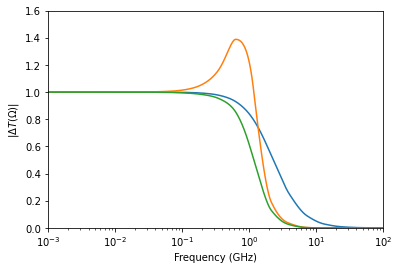

In [7]:
fGHz = wH*1e3/2/np.pi
plt.semilogx(fGHz,Tw_F/Tw_F[0])
plt.semilogx(fGHz,Tw_NU/Tw_NU[0])
plt.semilogx(fGHz,Tw_RTA/Tw_RTA[0])
plt.xlim([0.001,fGHz_cut])
plt.ylim([0,1.6])

plt.xlabel('Frequency (GHz)')
plt.ylabel('|$\Delta T(\Omega)$|')

Text(0, 0.5, 'Normalized $\\Delta$T(K)')

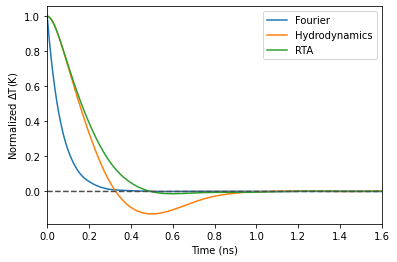

In [8]:
#tns_cut = 10
t_ns = t/1e3
plt.plot(t_ns,Tt_F/Tt_F[0])
plt.plot(t_ns,Tt_NU/Tt_NU[0])
plt.plot(t_ns,Tt_RTA/Tt_RTA[0])
plt.plot(t_ns,0*t,'--',color='0.3')
plt.xlim([0.0,tns_cut])
# plt.ylim([-0.1,1])
plt.legend(['Fourier','Hydrodynamics','RTA'])
plt.xlabel('Time (ns)')
plt.ylabel('Normalized $\Delta$T(K)')

In [9]:
if write_data:
    Lstr = str(Grating_Period*1e6)
    if is_isotope:
        if four_phonon:
            filename = 'TTG_'+Lstr+'um_'+'T'+str(T0)+'K_3ph-4ph.data'
        else:
            filename = 'TTG_'+Lstr+'um_'+'T'+str(T0)+'K_3ph.data'
    else:
        if four_phonon:
            filename = 'TTG_'+Lstr+'um_'+'T'+str(T0)+'K_3ph-4ph-noiso.data'
        else:
            filename = 'TTG_'+Lstr+'um_'+'T'+str(T0)+'K_3ph-noiso.data'

    TD_TTGSig = np.array([t_ns[t_ns<tns_cut],Tt_F[t_ns<tns_cut]/np.max(Tt_F),Tt_NU[t_ns<tns_cut]/np.max(Tt_NU),Tt_RTA[t_ns<tns_cut]/np.max(Tt_RTA)])
    api_ph.write_2D_array(filename,TD_TTGSig,'# time(ns)  Fourier    CSA-BTE   RTA-BTE')
    
    FD_TTGSig = np.array([fGHz[fGHz<fGHz_cut],Tw_F[fGHz<fGHz_cut]/Tw_F[0],Tw_NU[fGHz<fGHz_cut]/Tw_NU[0],Tw_RTA[fGHz<fGHz_cut]/Tw_RTA[0]])
    api_ph.write_2D_array('FD-'+filename,FD_TTGSig.real,'# Freq(GHz)  Fourier    CSA-BTE   RTA-BTE')

In [10]:
print(Grating_Period*1e6)
print('TTG dip depth:')
print(np.min(Tt_NU[t_ns<tns_cut]/np.max(Tt_F)))
print('Dip time:')
print(t_ns[Tt_NU==Tt_NU.min()])

4.0
TTG dip depth:
-0.12859219247177192
Dip time:
[0.49950025]
